## Objective:
**The objective of this Case is to Predication of bike rental count on daily based on the environmental and seasonal settings**

In [1]:
import pandas as pd
import numpy as np

#For visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec 

#knn imputation
from fancyimpute import KNN 

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , RandomizedLasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.grid_search import GridSearchCV 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing

#Chi-square test
from scipy.stats import chi2_contingency

import os

#Exporting decision tree graph
from sklearn.tree import export_graphviz
import pydot

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
random.seed(50)

In [3]:
#importing day wise dataset
daily_data = pd.read_csv('day.csv')

#Checking the data size
print("Data set has %s rows and %s features" %(daily_data.shape))

Data set has 731 rows and 16 features


In [4]:
daily_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
#Head
daily_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
#As we can see some of the variables have been abriveated while other are not, renaming them to readable format
daily_data = daily_data.rename(columns = {'dteday' : 'date', 'yr' : 'year', 'mnth' : 'month', 'weathersit' : 'weather_type', 'hum' : 'humidity', 'cnt':'total_count'})

In [7]:
daily_data.head()

,instant,date,season,year,month,holiday,weekday,workingday,weather_type,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
#Changing to proper data types
daily_data['date'] = pd.to_datetime(daily_data.date)

#Categorical data
daily_data['season'] = daily_data.season.astype('category')
daily_data['year'] = daily_data.year.astype('category')
daily_data['month'] = daily_data.month.astype('category')
daily_data['holiday'] = daily_data.holiday.astype('category')
daily_data['weekday'] = daily_data.weekday.astype('category')
daily_data['workingday'] = daily_data.workingday.astype('category')
daily_data['weather_type'] = daily_data.weather_type.astype('category')

In [9]:
#Creating a new variable day
daily_data['day'] = daily_data['date'].apply(lambda x: x.day)

In [10]:
#Statistical measures of the numerical features
daily_data.describe()

,instant,temp,atemp,humidity,windspeed,casual,registered,total_count,day
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837,15.738714
std,211.165812,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452,8.809949
min,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000,1.000000
25%,183.500000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000,8.000000
50%,366.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000,16.000000
75%,548.500000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000,23.000000
max,731.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000,31.000000


## Missing Value

In [11]:
#Missing value
missing_val = pd.DataFrame(daily_data.isnull().sum())
missing_val
#No missing value in the entired data set

,0
instant,0
date,0
season,0
year,0
month,0
holiday,0
weekday,0
workingday,0
weather_type,0
temp,0


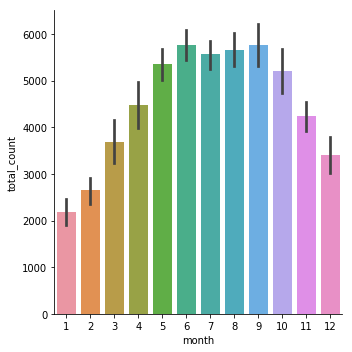

In [12]:
sns.catplot(x="month", y="total_count", data = daily_data, kind = 'bar')

## Outlier Analysis

**Checking the outlier on numerical data(Univariate analysis)**

In [13]:
numeric_variable = ['temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'total_count']

category_variables = ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weather_type']

In [14]:
#Defining a function to plot box
def box_univarite(col):
        sns.boxplot(y = col, data = daily_data, showmeans=True)
        plt.show()
        plt.savefig("Box.png")

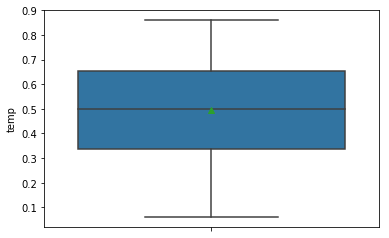

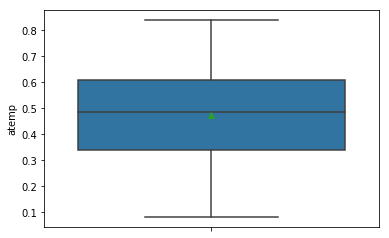

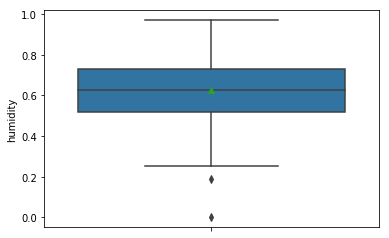

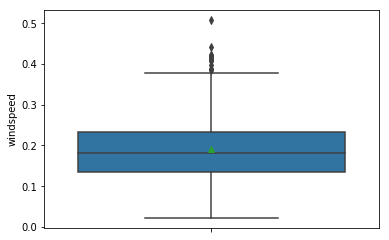

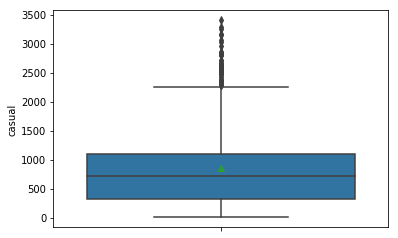

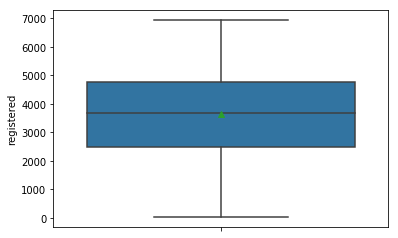

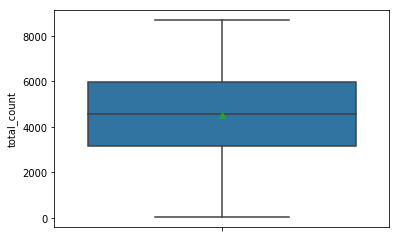

temp           None
atemp          None
humidity       None
windspeed      None
casual         None
registered     None
total_count    None
dtype: object

In [15]:
#Calling the function
daily_data[numeric_variable].apply(box_univarite)

**The above box plot shows the outliers present in humidity, windspeed and casual features. If we impute values for casual feature than we need to set the total_count feature as well as it depends on the casual and registered variables. total_count is the sum of casual and registered variable  **

In [16]:
#Removing the casual feature from the list
numeric_variable.remove('casual')

In [17]:
for i in numeric_variable:
    q75, q25 = np.percentile(daily_data.loc[:,i], [75, 25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(min), print(max)
    daily_data.loc[daily_data[i] < minimum,i] = np.nan
    daily_data.loc[daily_data[i] > maximum, i] = np.nan

<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>


In [18]:
daily_data.isnull().sum()

instant          0
date             0
season           0
year             0
month            0
holiday          0
weekday          0
workingday       0
weather_type     0
temp             0
atemp            0
humidity         2
windspeed       13
casual           0
registered       0
total_count      0
day              0
dtype: int64

In [19]:
date_values = daily_data.loc[:,'date']
#Dropping the date column as knn imputation works only on float and int variables
daily_data_knn = daily_data.drop('date', axis = 1)

In [20]:
#Imputing Outlier using KNN
daily_data = pd.DataFrame(KNN(k = 3).complete(daily_data_knn), columns = daily_data_knn.columns)

Imputing row 1/731 with 0 missing, elapsed time: 0.138
Imputing row 101/731 with 0 missing, elapsed time: 0.139
Imputing row 201/731 with 0 missing, elapsed time: 0.140
Imputing row 301/731 with 0 missing, elapsed time: 0.140
Imputing row 401/731 with 0 missing, elapsed time: 0.140
Imputing row 501/731 with 0 missing, elapsed time: 0.142
Imputing row 601/731 with 0 missing, elapsed time: 0.142
Imputing row 701/731 with 0 missing, elapsed time: 0.143


In [21]:
#Setting the data feature back to data frame
daily_data['date'] = date_values
#Setting the position to 2
cols_name = daily_data.columns.tolist()
column_to_move = "date"
new_position = 1
cols_name.insert(new_position, cols_name.pop(cols_name.index(column_to_move)))
daily_data = daily_data[cols_name]

**As we have imputed the values for the casual there will be conflict with the total_count on those rows as total_count is the sum fo casual and registered, Fixing it below**

In [22]:
daily_data['total_count'] = daily_data['casual'] + daily_data['registered']

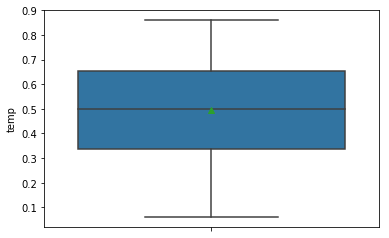

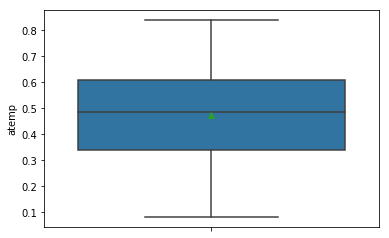

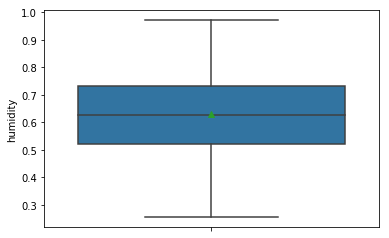

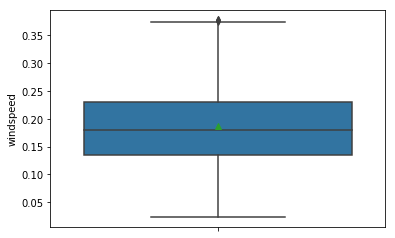

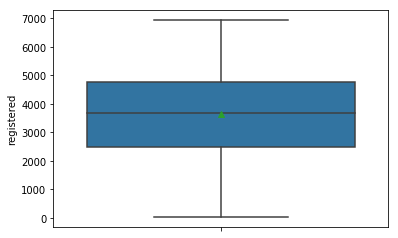

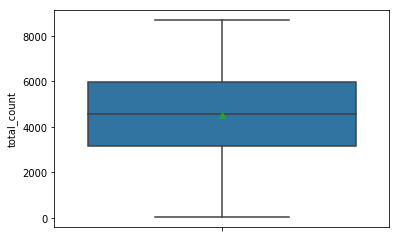

temp           None
atemp          None
humidity       None
windspeed      None
registered     None
total_count    None
dtype: object

In [23]:
#Confirming there are no outliers left
daily_data[numeric_variable].apply(box_univarite)

**Checking the outliers in the target variables based on the categorical features**

# Visulizing the distribution of varibles

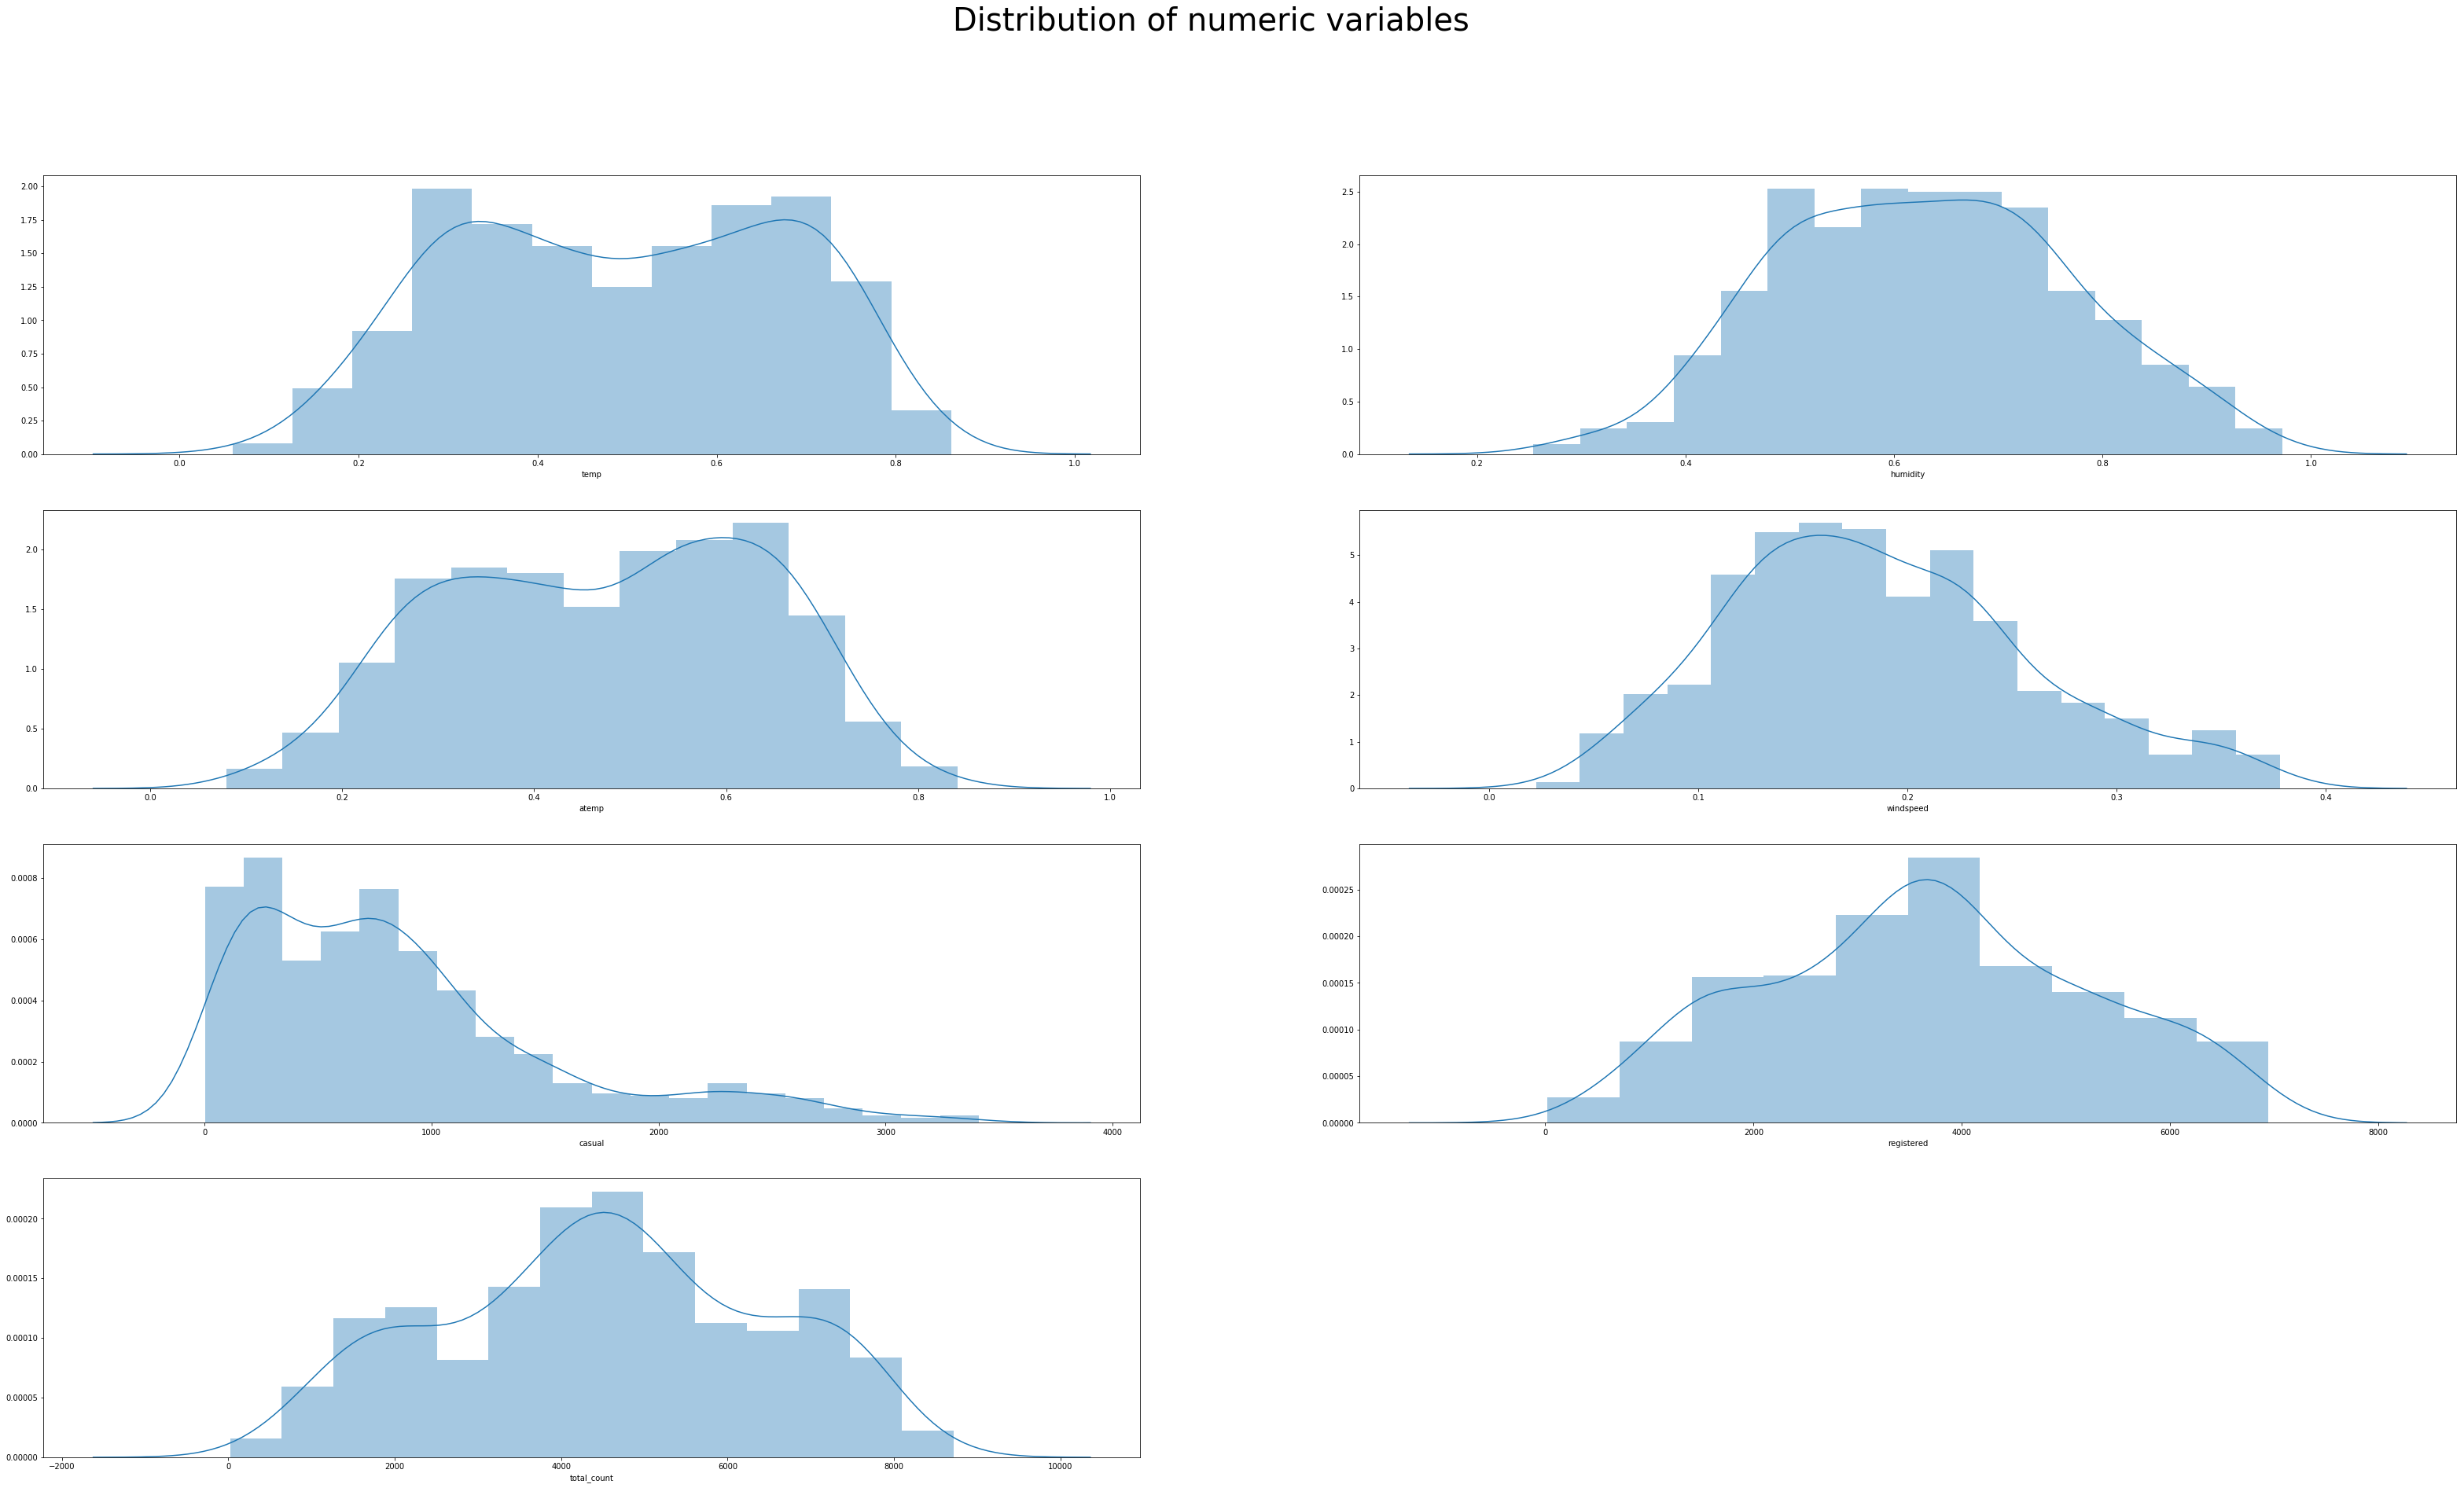

In [24]:
plt.figure(figsize=(55,30))
plt.suptitle("Distribution of numeric variables",fontsize=40, )
gridspec.GridSpec(4,2)
plt.savefig('Distribution.png')

#Countplot for the distance of employees from residence to work
plt.subplot2grid((4,2),(0,0))
sns.distplot(daily_data.temp)
plt.savefig('temp_distribution.png')


plt.subplot2grid((4,2),(0,1))
sns.distplot(daily_data.humidity);
plt.savefig('humidity_distribution.png')

#Countplot for no of social smokers and drinkers
plt.subplot2grid((4,2),(1,0))
sns.distplot(daily_data.atemp);
plt.savefig('atemp_distribution.png')

#Countplot for based on month and season
plt.subplot2grid((4,2),(1,1))
sns.distplot(daily_data.windspeed)
plt.savefig('windspeed_distribution.png')

plt.subplot2grid((4,2),(2,0))
sns.distplot(daily_data.casual)
plt.savefig('casual_distribution.png')

plt.subplot2grid((4,2),(2,1))
sns.distplot(daily_data.registered, bins=10)
plt.savefig('registered_distribution.png')

plt.subplot2grid((4,2),(3,0))
sns.distplot(daily_data.total_count)
plt.savefig('totalcount_distribution.png')

## Correlation Plot

**Correlation Plot for numeric variables**

* Temp and atemp has got high postive correlation among each other. The corrleation between these two with total_count seems to be vary prominant, which means total_count is influenced by temp and atemp at the same rate. We can remove one of these featurese as correlation among them is high and they are almost correlated in the same manner with total_count.
* Humidity is negatively correlated with total_count and is positively correlated with temp and atemp. It seems to be not an important feature in describing total_count.
* Windspeed is negatively correlated with all the other numeric variables.
* Casual and registered are positively correlated with total_count as expected. Total count is the sum of these two feature. We will not consider these features as they will be dropped during model building

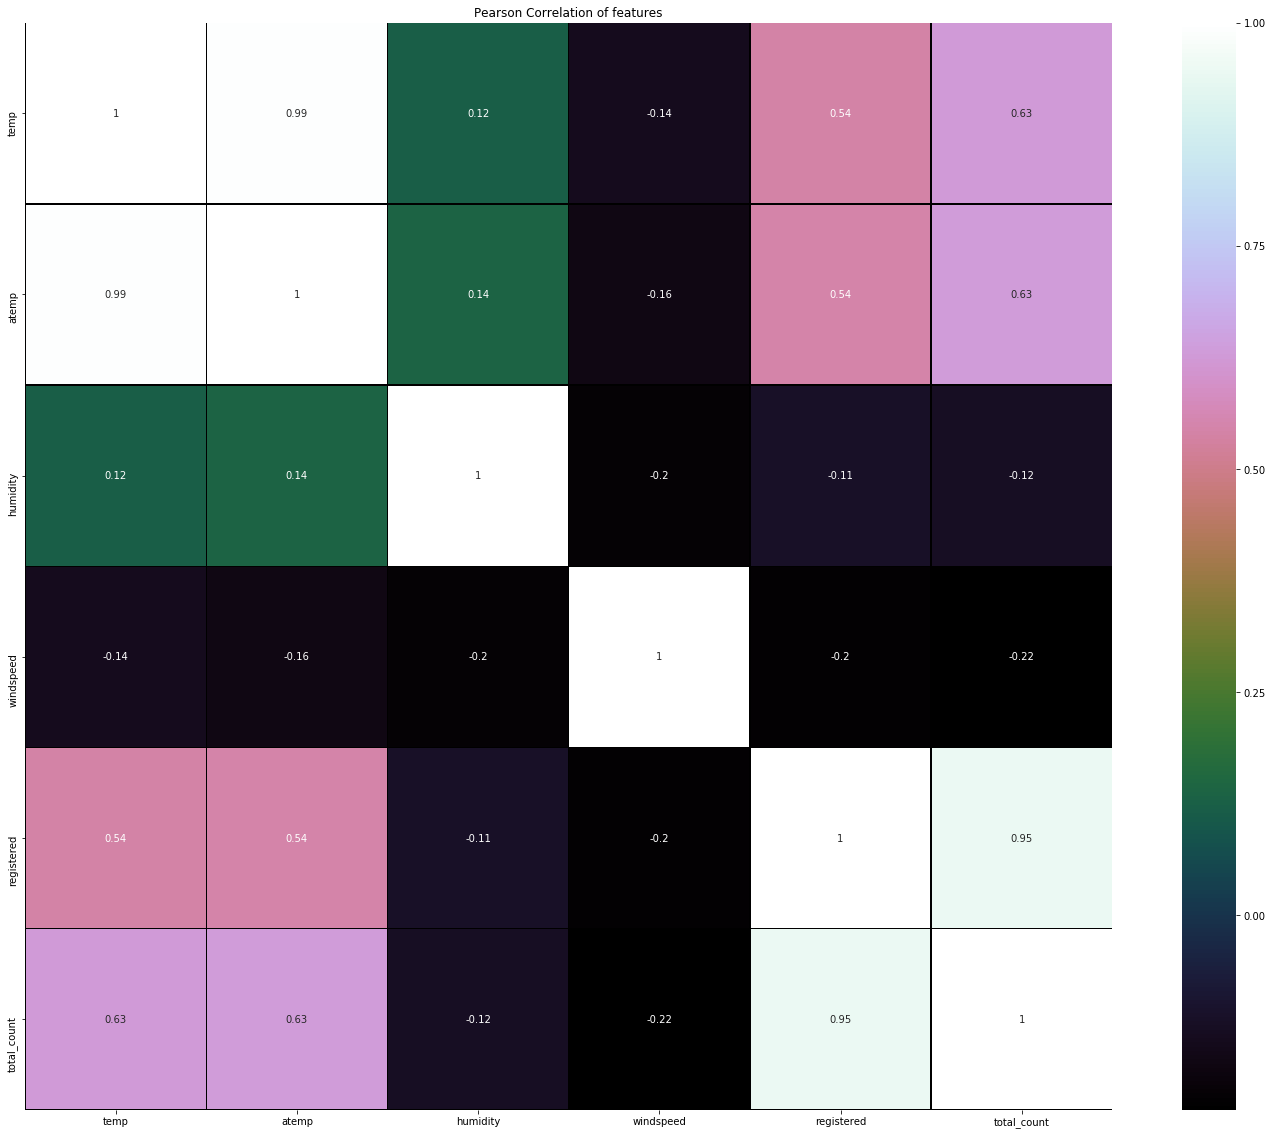

In [25]:
#Correlation Plot
churn_corr = daily_data.loc[: , numeric_variable]

f, ax = plt.subplots(figsize=(25, 20))

#Generating correlation matrix
corr = churn_corr.corr()

#Ploting using seaborn library
#annot shows the correlation number inside each block
plt.title('Pearson Correlation of features')
correlation_plot = sns.heatmap(corr, linewidths=0.4,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)
plt.savefig("correlation_plot.png")

*Regression plot in seaborn dipcts the relationship between two variable very well. Let's visualize what we calculated statistically above*

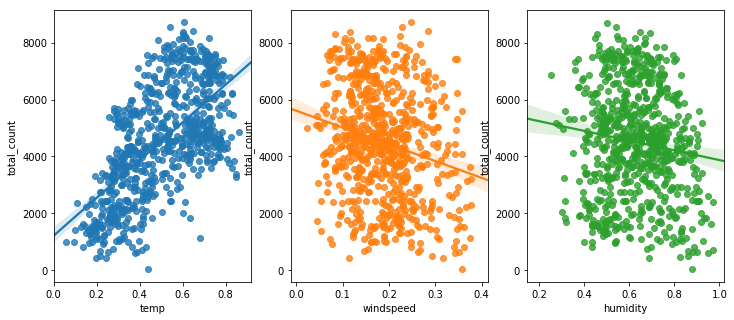

In [26]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="total_count", data=daily_data,ax=ax1)
sns.regplot(x="windspeed", y="total_count", data=daily_data,ax=ax2)
sns.regplot(x="humidity", y="total_count", data=daily_data,ax=ax3)

**Correlation between categorical variable and Target Variable(total_count)**

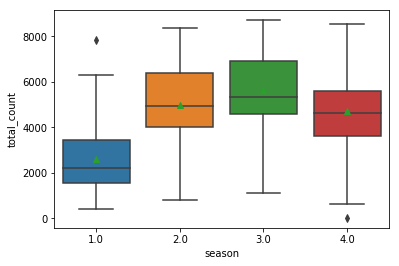

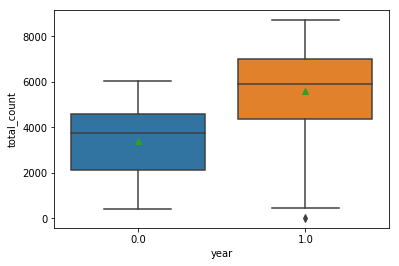

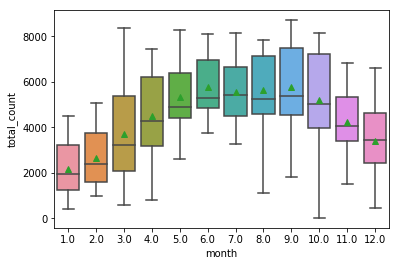

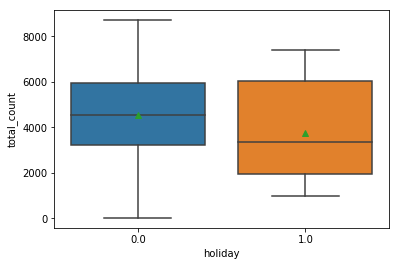

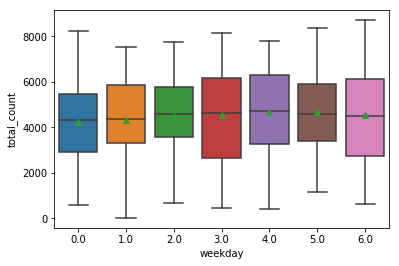

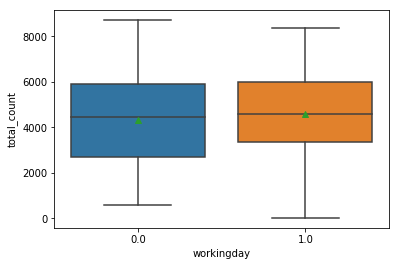

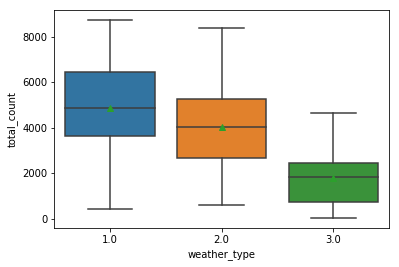

season          None
year            None
month           None
holiday         None
weekday         None
workingday      None
weather_type    None
dtype: object

In [27]:
def box(col):
    sns.boxplot(x= col, y = daily_data['total_count'], showmeans=True)
    plt.show()
    
daily_data[category_variables].apply(box)

** Chi-square test between two categorical variables **

* Some inferences from chisquare test:
* p value between season and weather type is less than 0.05, which means both features depend on each other which seems to be
  quite obivious as there is a specific weather in specific season.
* Holiday, weekday and working day has got very less p value which means they are highly related with each other, which again is
  quite obvious as when they is a holiday; it's not a working day and it's has highily significant with weekday as majority of 
  holiday falls on Monday(1).
* Weekday and working day are very highly associated with each other as weekday (0 and 6) are non working day all the time. 

In [28]:
#Finding correlation between categorical variables
category = daily_data.loc[:, category_variables]

#Factorinzing the columns
factors_paired = [(i,j) for i in category.columns.values for j in category.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    #print(f[0], f[1])
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(category[f[0]], category[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      #for same factor pair
        chi2.append(0)
        p_values.append(0)
chi2 = np.array(p_values).reshape((7,7)) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index = category.columns.values, columns=category.columns.values)
#Saving the data frame as image
chi2.to_html('chi.html')
chi2

,season,year,month,holiday,weekday,workingday,weather_type
season,0.000000,0.999929,0.000000,6.831687e-01,1.000000e+00,8.865568e-01,0.021179
year,0.999929,0.000000,1.000000,9.949247e-01,9.999996e-01,9.799434e-01,0.127379
month,0.000000,1.000000,0.000000,5.593083e-01,1.000000e+00,9.933495e-01,0.014637
holiday,0.683169,0.994925,0.559308,0.000000e+00,8.567055e-11,4.033371e-11,0.600857
weekday,1.000000,1.000000,1.000000,8.567055e-11,0.000000e+00,6.775031e-136,0.278459
workingday,0.886557,0.979943,0.993350,4.033371e-11,6.775031e-136,0.000000e+00,0.253764
weather_type,0.021179,0.127379,0.014637,6.008572e-01,2.784593e-01,2.537640e-01,0.000000


In [29]:
category.columns.values

array(['season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather_type'], dtype=object)

In [30]:
daily_data.head()

,instant,date,season,year,month,holiday,weekday,workingday,weather_type,temp,atemp,humidity,windspeed,casual,registered,total_count,day
0,1.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0,1.0
1,2.0,2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0,2.0
2,3.0,2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0,3.0
3,4.0,2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0,4.0
4,5.0,2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0,5.0


In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('total_count ~ season',
                data=daily_data).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print (aov_table)

                sum_sq     df           F        PR(>F)
season    4.517974e+08    1.0  143.967653  2.133997e-30
Residual  2.287738e+09  729.0         NaN           NaN


## Feature Importance

**Performing feature importance using 3 techniques to get to know which variables is most important in predicting our target variable i.e which is providing more information to the target variable**

In [32]:
# First extract the target variable which is our total_count
Y = daily_data.total_count.values
# Drop the unnecssary variabels
data_without_target = daily_data.drop(['total_count', 'date', 'registered', 'casual'], axis=1)
X = data_without_target.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = data_without_target.columns

In [33]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [34]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlogit = RandomizedLasso(alpha=0.04)
rlogit.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlogit.scores_), colnames)
print('finished')

finished


In [35]:
# Construct our logistic Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select = 1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [36]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators = 50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

building tree 1 of 50building tree 2 of 50building tree 3 of 50


building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50building tree 11 of 50building tree 12 of 50


building tree 13 of 50
building tree 14 of 50building tree 15 of 50building tree 16 of 50


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50building tree 37 of 50

building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


In [37]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	RF	RFE	rlasso/Stability	Mean
instant	1.0	0.25	0.0	0.42
season	0.0	0.42	1.0	0.47
year	0.0	0.75	0.96	0.57
month	0.01	0.33	0.99	0.44
holiday	0.0	0.58	1.0	0.53
weekday	0.02	0.0	1.0	0.34
workingday	0.01	0.08	1.0	0.36
weather_type	0.02	0.5	1.0	0.51
temp	0.2	0.67	0.9	0.59
atemp	0.13	1.0	1.0	0.71
humidity	0.09	0.83	1.0	0.64
windspeed	0.04	0.92	1.0	0.65
day	0.05	0.17	1.0	0.41


In [38]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

D:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Anaconda\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


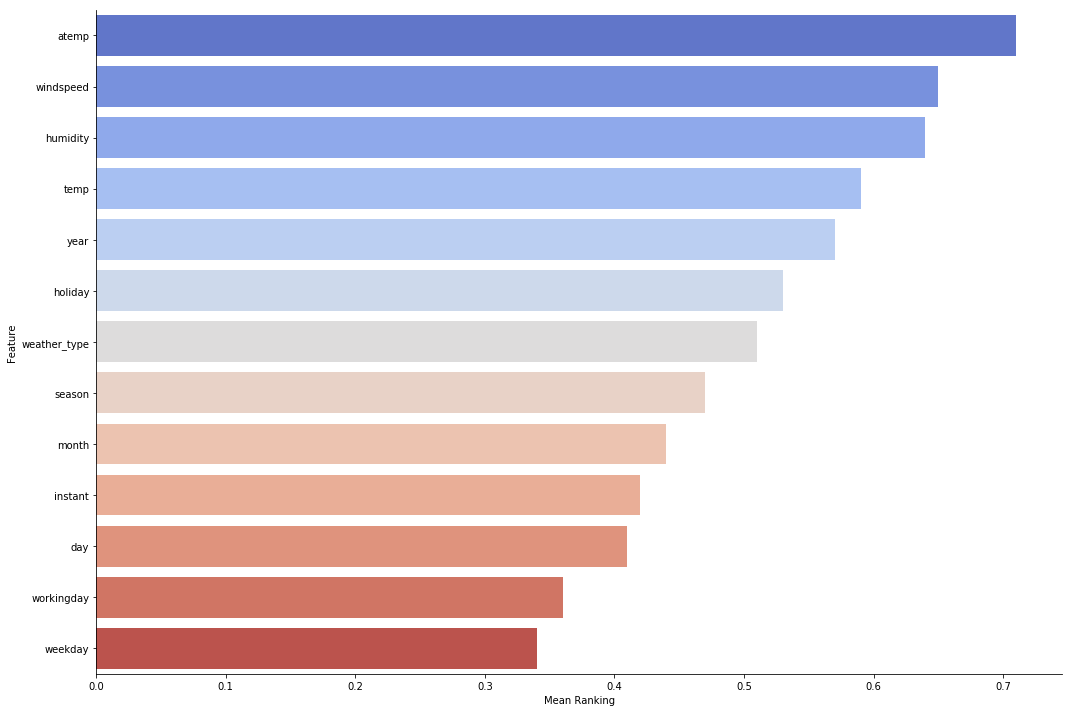

In [39]:
# Let's plot the ranking of the features
plt.figure(figsize=(25,30))
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=10, aspect=1.5, palette='coolwarm')
plt.savefig('feature_importance.png')

## EDA

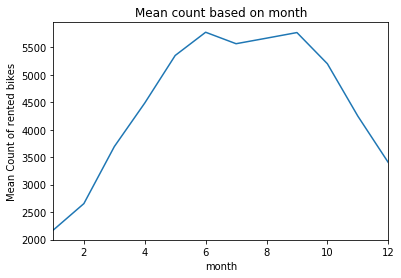

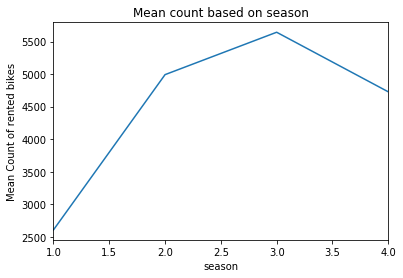

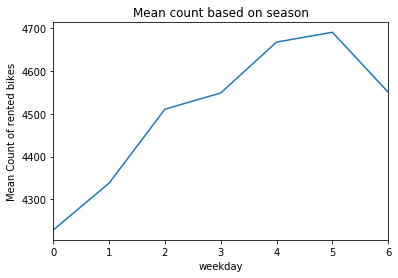

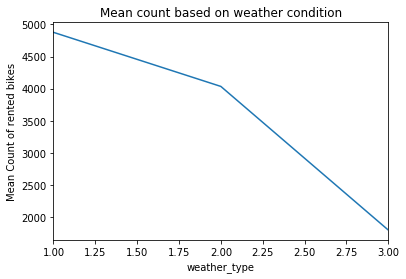

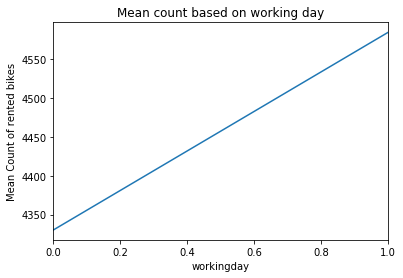

In [40]:
var = daily_data.groupby('month')['total_count'].mean()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Month of the year')  #X-axis label
ax1.set_ylabel('Mean Count of rented bikes') #Y-axis label
ax1.set_title("Mean count based on month") #Chart title
var.plot(kind='line')
plt.savefig('GP_MM.png')

season_wise = daily_data.groupby('season')['total_count'].mean()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('season of the year')  #X-axis label
ax1.set_ylabel('Mean Count of rented bikes') #Y-axis label
ax1.set_title("Mean count based on season") #Chart title
season_wise.plot(kind='line')
plt.savefig('GP_Seasons.png')

day_of_week = daily_data.groupby('weekday')['total_count'].mean().sort_index()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Day of the week')  #X-axis label
ax1.set_ylabel('Mean Count of rented bikes') #Y-axis label
ax1.set_title("Mean count based on season") #Chart title
day_of_week.plot(kind='line')
plt.savefig('GP_DOW.png')

#Total absent hours based on months
weather_condition = daily_data.groupby('weather_type')['total_count'].mean()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Weather Condition')  #X-axis label
ax1.set_ylabel('Mean Count of rented bikes') #Y-axis label
ax1.set_title("Mean count based on weather condition") #Chart title
weather_condition.plot(kind='line')
plt.savefig('GP_WT.png')

#Total absent hours based on days
is_workingday = daily_data.groupby('workingday')['total_count'].mean()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Working day or not')  #X-axis label
ax1.set_ylabel('Mean Count of rented bikes') #Y-axis label
ax1.set_title("Mean count based on working day") #Chart title
is_workingday.plot(kind='line')
plt.savefig('GP_WorkDay.png')

In [41]:
#There are 21 holidays in the 2 years
print("Mean of total count during only holiday not including weekends %s" %(daily_data[daily_data.holiday == 1].total_count.mean()))

#Mean of total count when there is weekend but not holiday
print("Mean of total count during only weekend %s" %(daily_data.query('workingday == 0 & holiday == 0').total_count.mean()))
#There are 210 weekends in 2 years

#Mena during working day when there is no holiday and weekend
print("Mean of total count during only working days %s" %(daily_data.query('workingday == 1').total_count.mean()))
#There are 500 working days in 2 years

Mean of total count during only holiday not including weekends 3735.0
Mean of total count during only weekend 4389.685714285714
Mean of total count during only working days 4584.82


In [42]:
daily_data.humidity.describe()

count    731.000000
mean       0.629504
std        0.140064
min        0.254167
25%        0.521041
50%        0.627500
75%        0.730833
max        0.972500
Name: humidity, dtype: float64

In [43]:
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

[Text(0.5,1,'Season wise daily distribution of counts')]

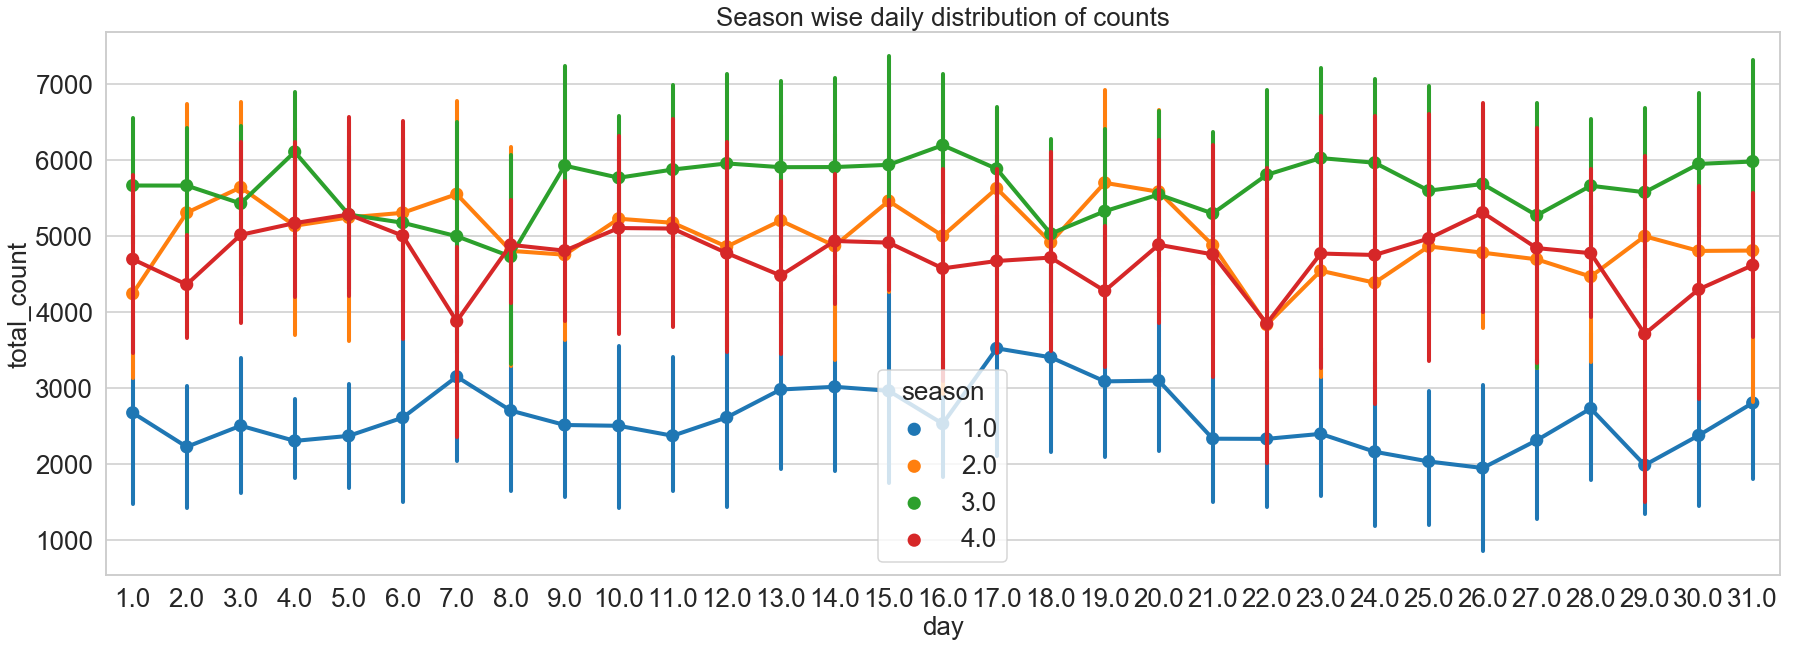

In [44]:
fig,ax = plt.subplots()
sns.pointplot(data=daily_data[['day',
                           'total_count',
                           'season']],
              x='day',
              y='total_count',
              hue='season',
              ax=ax)
ax.set(title="Season wise daily distribution of counts")

[Text(0.5,1,'Weather_type wise hourly distribution of counts')]

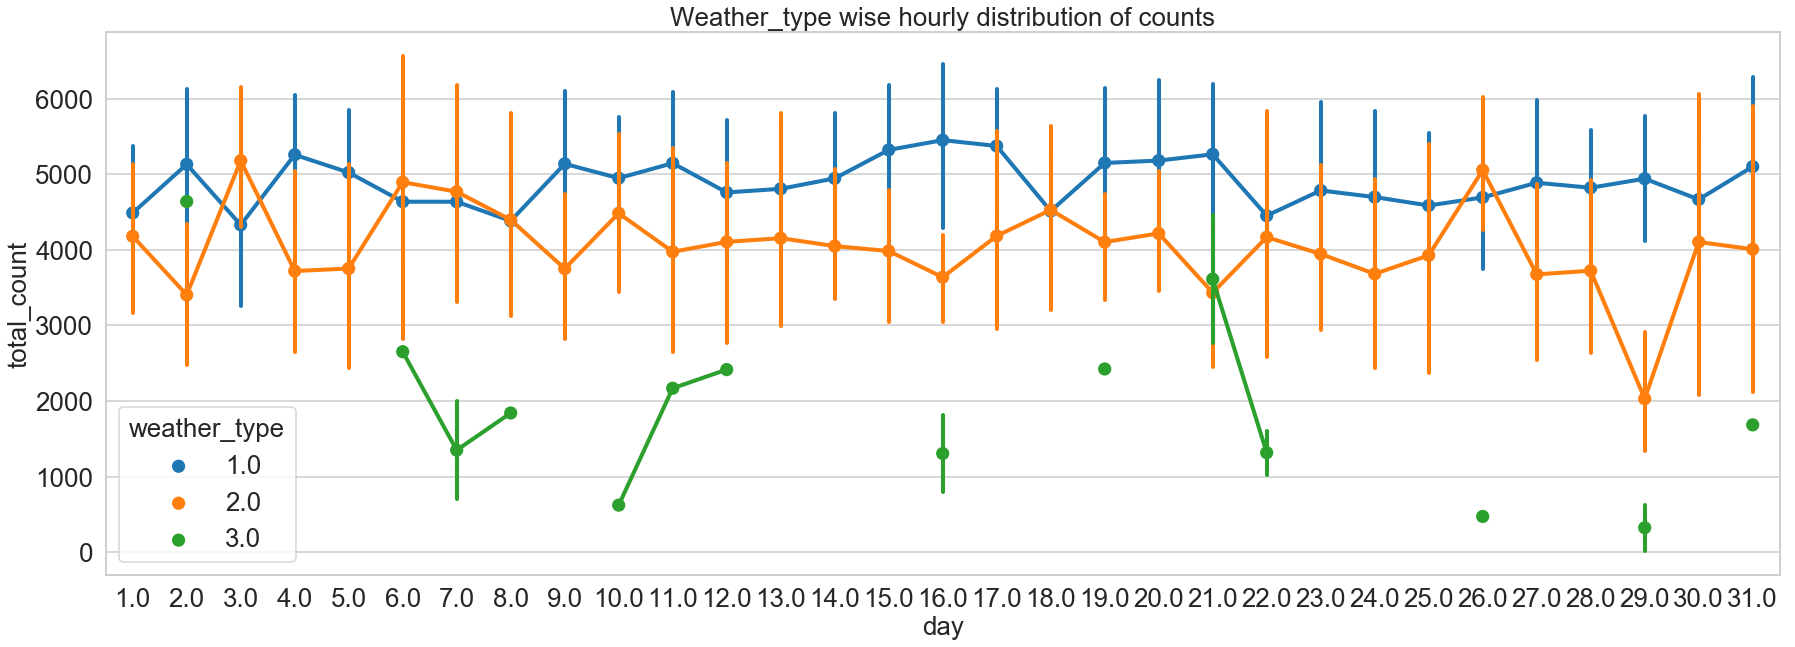

In [45]:
fig,ax = plt.subplots()
sns.pointplot(data=daily_data[['day',
                           'total_count',
                           'weather_type']],
              x='day',
              y='total_count',
              hue='weather_type',
              ax=ax)
ax.set(title="Weather_type wise hourly distribution of counts")

In [46]:
daily_data.columns

Index(['instant', 'date', 'season', 'year', 'month', 'holiday', 'weekday',
       'workingday', 'weather_type', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'total_count', 'day'],
      dtype='object')

In [47]:
#Moving the postion of day variable at 2nd 
cols_name = daily_data.columns.tolist()
column_to_move = "day"
new_position = 2
cols_name.insert(new_position, cols_name.pop(cols_name.index(column_to_move)))
daily_data = daily_data[cols_name]

## Feature Scaling 

In [48]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(daily_data[['total_count']])

In [49]:
scaled_data = pd.DataFrame(scaled_data)
scaled_data = scaled_data.rename(columns = {0 : 'total_count'})

## Model Generation

In [50]:
#Features to be dropped
dropFeatures = ['casual', "date","registered", 'temp', 'instant', 'day']

In [51]:
daily_data.head()

,instant,date,day,season,year,month,holiday,weekday,workingday,weather_type,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1.0,2011-01-01,1.0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
1,2.0,2011-01-02,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
2,3.0,2011-01-03,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
3,4.0,2011-01-04,4.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
4,5.0,2011-01-05,5.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0


In [52]:
#Saving the features and target varibale into different dataframe
X = daily_data.iloc[:, 0:16]
Y = daily_data.iloc[:,16:17]

In [53]:
#Splitting into train and test, with 80:20 ratio
x_train, x_cv, y_train, y_cv = train_test_split(X, scaled_data , test_size = 0.2, random_state = 50)

In [54]:
yLabels = y_train["total_count"]
yLablesRegistered = x_train["registered"]
yLablesCasual = x_train["casual"]
ytestLabels = y_cv["total_count"]

In [55]:
x_train  = x_train.drop(dropFeatures,axis=1)
x_cv  = x_cv.drop(dropFeatures,axis=1)

## Gradient Boosting

In [56]:
gbm = GradientBoostingRegressor(n_estimators=100, alpha=0.01, max_depth = 3, random_state = 10)

gbm.fit(x_train, yLabels)
preds = gbm.predict(x_cv)

In [57]:
#R -square
score = gbm.score(x_train, yLabels)
print ('GBM R square: %.4f' % score)

#RMSE
mse = mean_squared_error(preds, ytestLabels)
rmse = np.sqrt(mse)
print('Gradient Boosting RMSE: %.4f' % rmse)

GBM R square: 0.9555
Gradient Boosting RMSE: 0.0774


In [58]:
#Basic model paramters 
gbm

GradientBoostingRegressor(alpha=0.01, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False)

## Tuning the model using GridSearch

In [59]:
#Tuning for the no of estimator taking the basic value of min_samples_Split and other parameters based on the no of observation
#and the no of features we have
param_test1 = {'n_estimators':np.arange(20, 100,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=3, min_samples_leaf = 50,max_depth=7,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_train, yLabels)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=3,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': array([20, 30, 40, 50, 60, 70, 80, 90])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [60]:
#We got the n_estimator value as 90
gsearch1.best_params_

{'n_estimators': 90}

In [61]:
#Tuning the max_depth and min_samples_Split
param_test2 = {'max_depth':np.arange(3,16,2), 'min_samples_split':np.arange(3,30,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,n_estimators=90, min_samples_leaf = 50, max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test2, n_jobs=4,iid=False, cv=5)
gsearch2.fit(x_train, yLabels)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=90, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': array([ 3,  5,  7,  9, 11, 13, 15]), 'min_samples_split': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [62]:
gsearch2.best_params_
#Got the max_depth': 7, 'min_samples_split': 3

{'max_depth': 7, 'min_samples_split': 3}

In [63]:
#Tuning min_samples_leaf with taking min_samples split again
param_test3 = {'min_samples_split':np.arange(3,90,2), 'min_samples_leaf':np.arange(3, 50, 4)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=90, max_depth = 7, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, n_jobs=4, iid=False, cv=5)
gsearch3.fit(x_train, yLabels)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=90, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89]), 'min_samples_leaf': array([ 3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [64]:
gsearch3.best_params_
#Got the {'min_samples_leaf': 7, 'min_samples_split': 65

{'min_samples_leaf': 7, 'min_samples_split': 65}

In [65]:
from sklearn import cross_validation, metrics

In [66]:
#Tuning the max_features
param_test4 = {'max_features':np.arange(2,10,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=90, min_samples_split = 65, max_depth = 7, min_samples_leaf = 7, subsample=0.8, random_state=10), 
param_grid = param_test4, n_jobs=4, iid=False, cv=5)
gsearch4.fit(x_train, yLabels)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=7,
             min_samples_split=65, min_weight_fraction_leaf=0.0,
             n_estimators=90, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [67]:
gsearch4.best_params_
#GOt 'max_features': 3

{'max_features': 3}

In [68]:
#Tuning the subsample
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=90, min_samples_split = 65, max_depth = 7, min_samples_leaf = 7, max_features = 3,subsample=0.8, random_state=10), 
param_grid = param_test5, n_jobs=4, iid=False, cv=5)
gsearch5.fit(x_train, yLabels)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=7,
             min_samples_split=65, min_weight_fraction_leaf=0.0,
             n_estimators=90, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [69]:
gsearch5.best_params_
#Got the subsample value as 0.8

{'subsample': 0.8}

**Buiding gbm model based on the tuned parameters obtained after performing GribSearchCV**

In [70]:
gbm_tune = GradientBoostingRegressor(learning_rate=0.1, n_estimators=90, min_samples_split = 65, max_depth = 7, min_samples_leaf = 7, max_features = 3,subsample=0.8, random_state=10)

# Train the model
#yLabelsLog = np.log1p(yLabels)
#yLabelsLogtest = np.log1p(ytestLabels)

gbm_tune.fit(x_train, yLabels)
preds = gbm_tune.predict(x_cv)
#print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLogtest),np.exp(preds),False))
#R -square
score = gbm_tune.score(x_train, yLabels)
print ('GBM R square: %.4f' % score)

#RMSE
mse = mean_squared_error(preds, ytestLabels)
rmse = np.sqrt(mse)
print('Gradient Boosting RMSE: %.4f' % rmse)

GBM R square: 0.9614
Gradient Boosting RMSE: 0.0781


**The tuned model gives is almost gives almost similar accuracy statistics then our basic model, but there is an imporvement in R square. ANd here we are using min_sample_split of 65 as compared to min_sample_split of 2 in our basic model which can lead of overfitting probelm. We will go ahead with our tuned model.

## Visualizing the Model

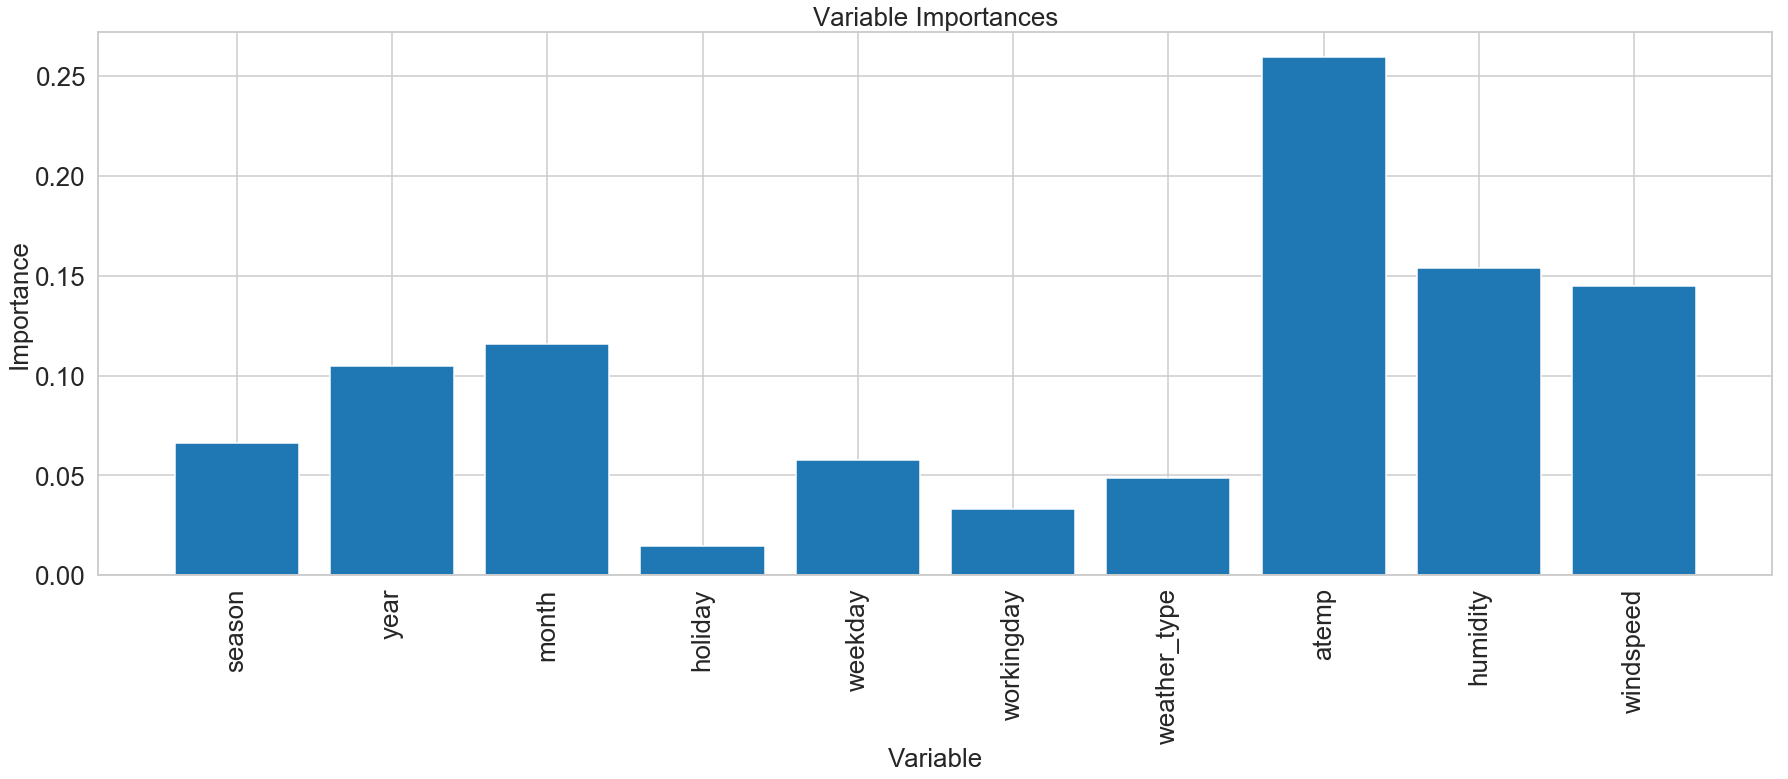

In [71]:
importances = list(gbm_tune.feature_importances_)
feature_list = x_train.columns
# Set the style
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [72]:
preds=preds[:, np.newaxis]
predictions = scaler.inverse_transform(preds)

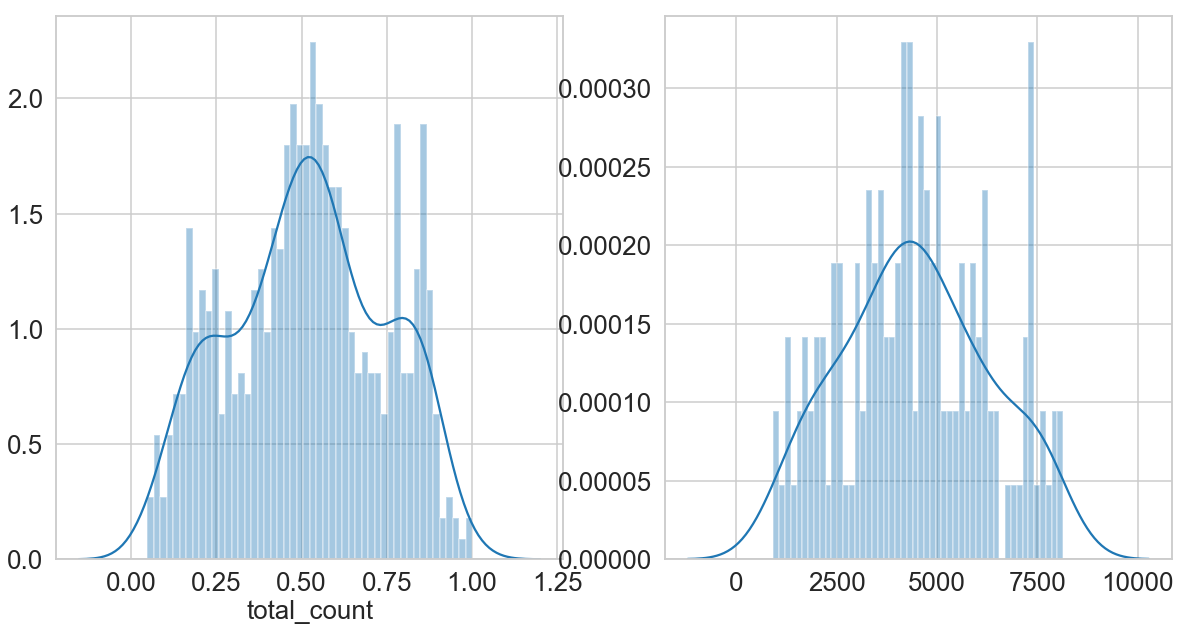

In [73]:
predsTest = gbm_tune.predict(X= x_cv)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,10)
sns.distplot(yLabels,ax=ax1,bins=50)
sns.distplot(predictions,ax=ax2,bins=50)

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
#yLabelsLog = np.log1p(yLabels)
rfModel.fit(x_train, yLabels)
preds = rfModel.predict(x_cv)


#R -square
score = rfModel.score(x_train, yLabels)
print ('Random Forest R square: %.4f' % score)


#RMSE
mse = mean_squared_error(preds, ytestLabels)
rmse = np.sqrt(mse)
print('Random Forest RMSE: %.4f' % rmse)

Random Forest R square: 0.9840
Random Forest RMSE: 0.0854


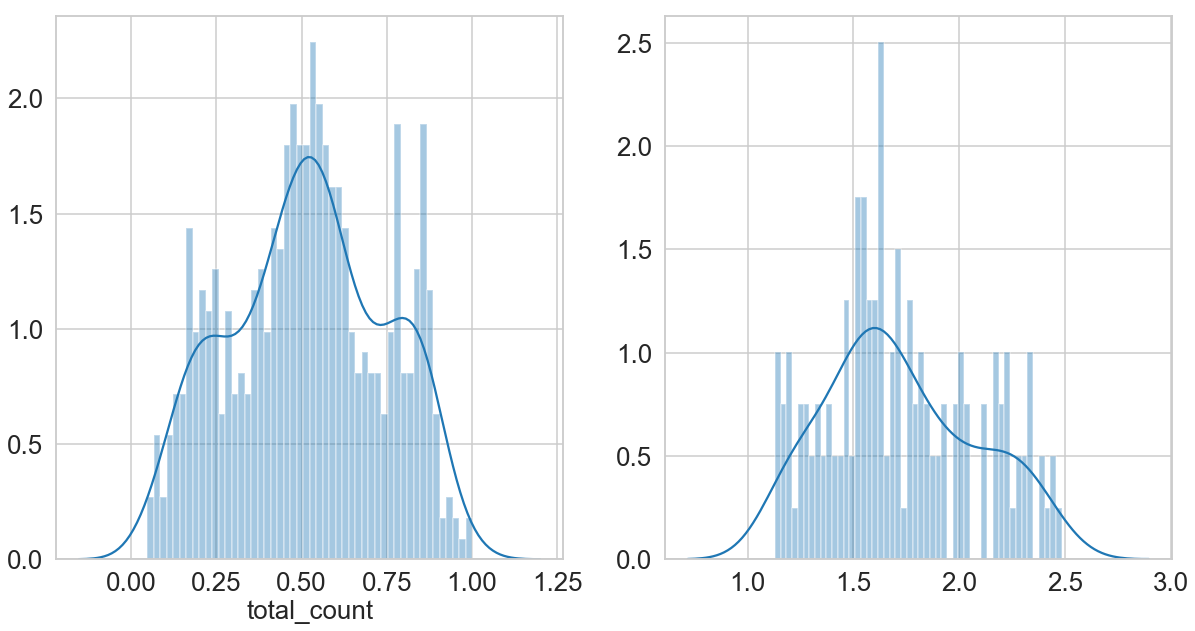

In [77]:
predsTest = rfModel.predict(X= x_cv)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,10)
sns.distplot(yLabels,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

## Decision Tree

In [78]:
dtmodel = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)

#yLabelsLog = np.log1p(yLabels)
#yLabelsLogtest = np.log1p(ytestLabels)

dtmodel.fit(x_train, yLabels)

predictions = dtmodel.predict(x_cv)
dtmodel
#print ("RMSLE Value Decision tree", rmsle(np.exp(yLabelsLogtest),np.exp(preds),False))

#print ("RMSLE Value For Decision Tree: ",rmsle(np.exp(yLabelsLogtest),np.exp(predictions),False))
#R -square
score = dtmodel.score(x_train, yLabels)
print ('Decsion Tree R square: %.4f' % score)


#RMSE
mse = mean_squared_error(predictions, ytestLabels)
rmse = np.sqrt(mse)
print('Decision tree RMSE: %.4f' % rmse)


Decsion Tree R square: 0.8252
Decision tree RMSE: 0.1171
